In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from itertools import chain
import datetime
import time
import os
import math

import sklearn.neighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import geopy.distance
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

## Query by Station

In [2]:
# convert station list to array
# there should be better ways but I didn't find any...
rows, cols = (119503, 9)
Stations= [[0 for i in range(cols)] for j in range(rows)]
with open('ghcnd-stations.txt','r') as f:
    s = f.readlines()
i = 0
for station in s:
    Stations[i][0]=station[:11] #ID
    Stations[i][1]=float(station[12:20]) # Latitude
    Stations[i][2]=float(station[21:30]) # Lontitude
    Stations[i][3]=float(station[31:37]) # Elevatioin
    Stations[i][4]=station[38:40].strip() # state
    Stations[i][5]=station[41:71].strip() # name
    Stations[i][6]=station[72:75].strip() # GSN flag
    Stations[i][7]=station[76:79].strip() # HCN/CRN flag
    WMO = station[80:85].strip()
    if len(WMO)>0:
        Stations[i][8]=int(WMO) # WMO ID
    else:
        Stations[i][8]=""
    i +=1


In [3]:
# Station_df as the station dataframe
my_states = ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
             'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
             'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ',
             'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
             'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
#No Alaska or Hawaii

cols = ["ID","Latitude","Longtitude","Elevation","State","Name","GSN","HCN/CRN","WMO"]
Station_df = pd.DataFrame (Stations, columns = cols)
Station_df.set_index('ID')
Station_df = Station_df[["ID","Latitude","Longtitude","Elevation","State","Name"]]
Station_df = Station_df.query('State==@my_states')
#Station_df.style.set_properties(subset="Name",**{'text-align': 'left'})
Station_df.head()

,ID,Latitude,Longtitude,Elevation,State,Name
52607,US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA)
52608,US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW
52609,US10adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S
52610,US10adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW
52611,US10adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW


In [6]:
filename_snow = "SNOW.csv"
filename_prcp = "PRCP.csv"
filename_temp = "TAVG.csv"

cols_snow = ['ID', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 
             'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 
             'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 
             'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S43', 'S44', 
             'S45', 'S46', 'S47', 'S48', 'S49', 'S50', 'S51', 'S52', 'S53']

cols_prcp = ['ID', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 
             'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 
             'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 
             'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 
             'P45', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52', 'P53']

cols_temp = ['ID', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11',
             'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 
             'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 
             'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 
             'T45', 'T46', 'T47', 'T48', 'T49', 'T50', 'T51', 'T52', 'T53']

df_s1 = pd.read_csv(filename_snow, names = cols_snow, low_memory=False).iloc[:][3:].set_index('ID')
df_p1 = pd.read_csv(filename_prcp, names = cols_prcp, low_memory=False).iloc[:][3:].set_index('ID')
df_t1 = pd.read_csv(filename_temp, names = cols_temp, low_memory=False).iloc[:][3:].set_index('ID')

In [7]:
df_s1.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S44,S45,S46,S47,S48,S49,S50,S51,S52,S53
ID,,,,,,,,,,,,,,,,,,,,,
AQC00914000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AQW00061705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BF1BI000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
BF1CE000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
BF1CE000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [8]:
df_p1.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P44,P45,P46,P47,P48,P49,P50,P51,P52,P53
ID,,,,,,,,,,,,,,,,,,,,,
AE000041196,34.0,42.36363636363637,20.46153846153846,21.416666666666668,34.0,5.454545454545454,2.333333333333333,17.0,32.2,1.3333333333333333,...,3.272727272727273,37.25,0.0,10.444444444444443,47.92307692307693,78.36363636363636,95.8,16.416666666666668,29.09090909090909,0.0
AEM00041194,6.777777777777778,62.45,85.77777777777777,16.11111111111111,4.222222222222221,6.833333333333332,5.166666666666667,20.263157894736842,32.68421052631579,0.7894736842105263,...,0.375,0.7647058823529411,18.41176470588235,20.47058823529412,12.294117647058822,61.411764705882355,44.27777777777778,18.894736842105264,18.33333333333333,7.611111111111112
AEM00041217,0.0,94.71428571428572,195.0,20.33333333333333,10.0,8.333333333333334,0.0,26.33333333333333,76.16666666666667,26.5,...,NaN,5.0,NaN,25.0,2.6666666666666665,12.666666666666664,195.33333333333331,11.6,25.0,36.0
AEM00041218,NaN,388.66666666666674,98.6,115.5,16.5,24.66666666666667,1.0,84.0,36.2,NaN,...,NaN,NaN,NaN,36.0,NaN,8.0,681.0,5.0,NaN,NaN
AFM00040938,232.5,495.5,45.5,718.5,335.6666666666667,923.5,560.0,57.33333333333334,89.5,200.5,...,517.6666666666666,0.0,8.333333333333334,449.5,190.5,495.0,145.33333333333334,76.0,731.5,20.0


In [9]:
df_t1.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53
ID,,,,,,,,,,,,,,,,,,,,,
AE000041196,1161.2272727272727,1328.7727272727273,1282.2272727272727,1291.409090909091,1343.0,1331.909090909091,1407.8636363636365,1456.1818181818182,1523.409090909091,1512.7272727272727,...,1929.6818181818185,1837.3636363636365,1743.8181818181818,1676.4545454545455,1608.8636363636365,1544.3636363636365,1494.1818181818182,1424.0,1394.1363636363635,432.2272727272728
AEM00041194,1247.2272727272727,1444.090909090909,1382.3181818181818,1388.7272727272727,1429.1818181818182,1431.090909090909,1498.0454545454545,1538.409090909091,1592.0454545454545,1581.7272727272727,...,2044.2727272727273,1946.6363636363642,1863.4545454545453,1779.2272727272727,1705.1363636363635,1652.6818181818182,1599.1818181818182,1534.7272727272727,1496.409090909091,470.9090909090909
AEM00041217,1182.909090909091,1377.9545454545455,1316.909090909091,1326.1818181818182,1378.1818181818182,1370.1363636363635,1451.409090909091,1490.3636363636365,1557.7727272727273,1538.5454545454545,...,1982.1363636363642,1892.4545454545453,1795.6363636363635,1719.2272727272727,1648.2727272727273,1584.3636363636365,1531.409090909091,1458.1818181818182,1421.2727272727273,445.27272727272725
AEM00041218,1145.1818181818182,1318.4545454545455,1244.409090909091,1282.3636363636365,1338.3636363636365,1347.409090909091,1450.0,1503.5,1567.3181818181818,1578.3636363636365,...,1981.5,1863.1818181818185,1762.4545454545455,1665.0454545454545,1588.8181818181818,1544.090909090909,1464.8181818181818,1397.9545454545455,1357.3181818181818,429.6363636363636
AFM00040938,323.6875,301.1875,279.125,394.0,483.4375,433.5625,513.6875,628.875,702.75,816.1875,...,961.6666666666665,889.2,747.0666666666667,641.3125,525.0625,592.6875,411.125,407.6875,391.8125,94.3125


### Min-Max normalization accross each measurement type

In [10]:
np_t1 = df_t1.to_numpy(dtype='float')
np_t2 = np.nan_to_num(np_t1)

tmax = np.max(np_t2)
tmin = np.min(np_t2)

print(tmax)
print(tmin)

np_t3 = (np_t2 - tmin) / (tmax - tmin)

print(np_t3)

16916.105263157893
-4755.411764705882
[[0.27301453 0.28074567 0.2785979  ... 0.28513979 0.28376177 0.23937591]
 [0.27698287 0.28606685 0.28321644 ... 0.29024913 0.288481   0.24116082]
 [0.27401501 0.28301509 0.28019824 ... 0.28671706 0.28501394 0.23997787]
 ...
 [0.27877198 0.28358244 0.28301938 ... 0.28711704 0.28653794 0.24093661]
 [0.27376797 0.27944568 0.27608182 ... 0.27790254 0.28373105 0.24059501]
 [0.26212282 0.27739478 0.27488604 ... 0.26527212 0.28188997 0.23998658]]


In [11]:
np_p1 = df_p1.to_numpy(dtype='float')
np_p2 = np.nan_to_num(np_p1)

pmax = np.max(np_p2)
pmin = np.min(np_p2)

print(pmax)
print(pmin)

np_p3 = (np_p2 - pmin) / (pmax - pmin)

print(np_p3)

19400.0
0.0
[[0.00175258 0.00218369 0.00105472 ... 0.00084622 0.00149953 0.        ]
 [0.00034937 0.00321907 0.00442153 ... 0.00097396 0.00094502 0.00039233]
 [0.         0.00488218 0.01005155 ... 0.00059794 0.00128866 0.00185567]
 ...
 [0.01939964 0.01780928 0.01561283 ... 0.02863402 0.02816044 0.00975515]
 [0.00626117 0.01249802 0.01409507 ... 0.01285931 0.01137113 0.00918213]
 [0.00785911 0.02295533 0.01868755 ... 0.01319191 0.01564235 0.01136168]]


In [12]:
np_s1 = df_s1.to_numpy(dtype='float')
np_s2 = np.nan_to_num(np_s1)

smax = np.max(np_s2)
smin = 0

print(smax)
print(smin)

np_s3 = (np_s2 - smin) / (smax - smin)

print(np_s3)

3111.5
0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Now we need to put our numpy arrays back into pandas to combine with station ID

In [13]:
df_t2_indeces = df_t1.reset_index().values[:, 0]
df_t2 = pd.DataFrame(np_t3, columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 
                                       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 
                                       'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 
                                       'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 
                                       'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 
                                       'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48', 'T49', 
                                       'T50', 'T51', 'T52', 'T53'], index = [df_t2_indeces])


df_t2.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53
AE000041196,0.273015,0.280746,0.278598,0.279022,0.281402,0.280890,0.284395,0.286625,0.289727,0.289234,...,0.308474,0.304214,0.299897,0.296789,0.293670,0.290694,0.288378,0.285140,0.283762,0.239376
AEM00041194,0.276983,0.286067,0.283216,0.283512,0.285379,0.285467,0.288557,0.290419,0.292894,0.292418,...,0.313761,0.309256,0.305418,0.301531,0.298112,0.295692,0.293223,0.290249,0.288481,0.241161
AEM00041217,0.274015,0.283015,0.280198,0.280626,0.283026,0.282654,0.286405,0.288202,0.291313,0.290425,...,0.310894,0.306756,0.302288,0.298763,0.295489,0.292540,0.290096,0.286717,0.285014,0.239978
AEM00041218,0.272274,0.280270,0.276853,0.278604,0.281188,0.281606,0.286340,0.288808,0.291753,0.292263,...,0.310865,0.305405,0.300757,0.296262,0.292745,0.290681,0.287023,0.283938,0.282063,0.239256
AFM00040938,0.234367,0.233329,0.232311,0.237612,0.241739,0.239438,0.243135,0.248450,0.251859,0.257093,...,0.263806,0.260462,0.253904,0.249024,0.243660,0.246780,0.238402,0.238244,0.237511,0.223783


In [14]:
df_p2_indeces = df_p1.reset_index().values[:, 0]
df_p2 = pd.DataFrame(np_p3, columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 
                                       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 
                                       'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 
                                       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 
                                       'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 
                                       'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 
                                       'P50', 'P51', 'P52', 'P53'], index = [df_p2_indeces])


df_p2.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P44,P45,P46,P47,P48,P49,P50,P51,P52,P53
AE000041196,0.001753,0.002184,0.001055,0.001104,0.001753,0.000281,0.000120,0.000876,0.001660,0.000069,...,0.000169,0.001920,0.000000,0.000538,0.002470,0.004039,0.004938,0.000846,0.001500,0.000000
AEM00041194,0.000349,0.003219,0.004422,0.000830,0.000218,0.000352,0.000266,0.001044,0.001685,0.000041,...,0.000019,0.000039,0.000949,0.001055,0.000634,0.003166,0.002282,0.000974,0.000945,0.000392
AEM00041217,0.000000,0.004882,0.010052,0.001048,0.000515,0.000430,0.000000,0.001357,0.003926,0.001366,...,0.000000,0.000258,0.000000,0.001289,0.000137,0.000653,0.010069,0.000598,0.001289,0.001856
AEM00041218,0.000000,0.020034,0.005082,0.005954,0.000851,0.001271,0.000052,0.004330,0.001866,0.000000,...,0.000000,0.000000,0.000000,0.001856,0.000000,0.000412,0.035103,0.000258,0.000000,0.000000
AFM00040938,0.011985,0.025541,0.002345,0.037036,0.017302,0.047603,0.028866,0.002955,0.004613,0.010335,...,0.026684,0.000000,0.000430,0.023170,0.009820,0.025515,0.007491,0.003918,0.037706,0.001031


In [15]:
df_s2_indeces = df_s1.reset_index().values[:, 0]
df_s2 = pd.DataFrame(np_s3, columns = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 
                                       'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 
                                       'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 
                                       'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 
                                       'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40', 'S41', 
                                       'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48', 'S49', 
                                       'S50', 'S51', 'S52', 'S53'], index = [df_s2_indeces])


df_s2.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S44,S45,S46,S47,S48,S49,S50,S51,S52,S53
AQC00914000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AQW00061705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BF1BI000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BF1CE000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BF1CE000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### This looks great, and the unit of precipitation is 1/10th of a mm, however we do have NaN values, so we will first cut all stations with NaNs

In [16]:
XP_num = df_p2.values[:, 1:].astype(float)
print(XP_num)

[[0.00218369 0.00105472 0.00110395 ... 0.00084622 0.00149953 0.        ]
 [0.00321907 0.00442153 0.00083047 ... 0.00097396 0.00094502 0.00039233]
 [0.00488218 0.01005155 0.00104811 ... 0.00059794 0.00128866 0.00185567]
 ...
 [0.01780928 0.01561283 0.01294072 ... 0.02863402 0.02816044 0.00975515]
 [0.01249802 0.01409507 0.01263531 ... 0.01285931 0.01137113 0.00918213]
 [0.02295533 0.01868755 0.01530584 ... 0.01319191 0.01564235 0.01136168]]


## Run a KMeans Model using just Precipitation

In [17]:
num_clust = 20

kmeans_XP = KMeans(n_clusters=num_clust, random_state=0).fit(XP_num)
kmeans_plabels = kmeans_XP.labels_
print(kmeans_plabels)

[ 2  2  2 ...  7 11  7]


In [18]:
cluster_IDs = df_p2.index.tolist()
cluster_IDs_list = []
for i in cluster_IDs:
    cluster_IDs_list.append(i[0])
    
print(cluster_IDs_list[0:10])

['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938', 'AFM00040948', 'AFM00040990', 'AG000060390', 'AG000060590', 'AG000060611']


In [19]:
df_kmeans_plabels = pd.DataFrame(list(zip(cluster_IDs_list, kmeans_plabels)),
               columns =['ID', 'kmeans_labels'])
df_kmeans_plabels.set_index('ID')
df_kmeans_plabels.head()

,ID,kmeans_labels
0,AE000041196,2
1,AEM00041194,2
2,AEM00041217,2
3,AEM00041218,2
4,AFM00040938,7


In [20]:
df_p_final = Station_df.set_index('ID').join(df_kmeans_plabels.set_index('ID'))
df_p_final.head()

,Latitude,Longtitude,Elevation,State,Name,kmeans_labels
ID,,,,,,
US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA),5.0
US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,2.0
US10adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S,3.0
US10adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,3.0
US10adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW,3.0


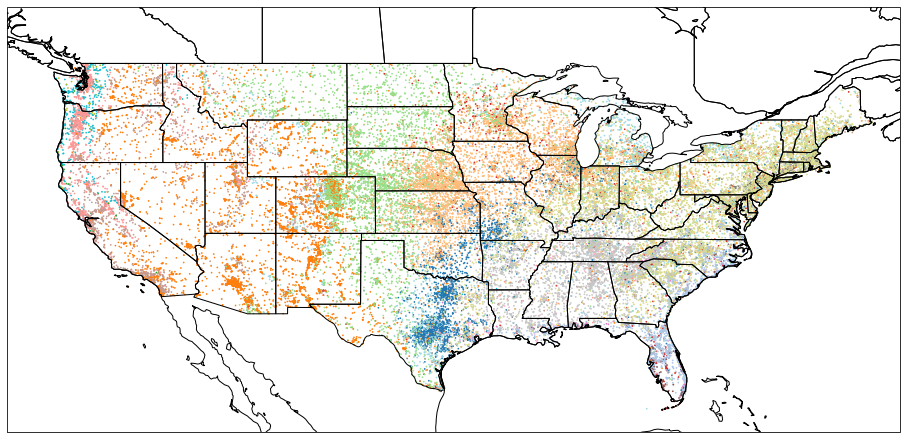

In [21]:
fig = plt.figure(figsize=(16,12))
m_usa = plt.axes(projection=ccrs.PlateCarree())
m_usa.set_extent([-128, -65, 23, 53], ccrs.PlateCarree())
m_usa.add_feature(cfeature.STATES)
m_usa.coastlines()

Lat = df_p_final["Latitude"].to_numpy()
Long = df_p_final["Longtitude"].to_numpy()
Labs = df_p_final["kmeans_labels"].to_numpy()

m_usa.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=0.5, c=Labs, cmap="tab20")

# Now that we have proven our model can create useful clusters with just precipitation data, we can append temperature and snow data per week and create a new model

### Append our Stations' precipitation, temp, and snow data horizontally

#### Snow data is mostly 0 for all stations which causes dissimilar locations to be clustered together, therefore we have dropped it

In [22]:
#df_final = pd.concat([df_p2, df_t2, df_s2])
df_final = pd.concat([df_p2, df_t2])
df_final

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53
AE000041196,0.001753,0.002184,0.001055,0.001104,0.001753,0.000281,0.000120,0.000876,0.001660,0.000069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEM00041194,0.000349,0.003219,0.004422,0.000830,0.000218,0.000352,0.000266,0.001044,0.001685,0.000041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEM00041217,0.000000,0.004882,0.010052,0.001048,0.000515,0.000430,0.000000,0.001357,0.003926,0.001366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEM00041218,0.000000,0.020034,0.005082,0.005954,0.000851,0.001271,0.000052,0.004330,0.001866,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFM00040938,0.011985,0.025541,0.002345,0.037036,0.017302,0.047603,0.028866,0.002955,0.004613,0.010335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZA000067743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.256623,0.257101,0.249852,0.245030,0.254204,0.261702,0.248841,0.257259,0.260838,0.237276
ZAM00067663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.219431,0.219431,0.219431,0.219431,0.230967,0.219431,0.219431,0.219431,0.231475,0.219431
ZI000067775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.288445,0.289429,0.289631,0.288238,0.285519,0.287157,0.284323,0.287117,0.286538,0.240937
ZI000067975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.277205,0.281985,0.275046,0.286490,0.284314,0.277242,0.279762,0.277903,0.283731,0.240595


In [23]:
X_final = df_final.values[:, 1:].astype(float)
X_final = np.nan_to_num(X_final)
print(X_final)

[[0.00218369 0.00105472 0.00110395 ... 0.         0.         0.        ]
 [0.00321907 0.00442153 0.00083047 ... 0.         0.         0.        ]
 [0.00488218 0.01005155 0.00104811 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.28711704 0.28653794 0.24093661]
 [0.         0.         0.         ... 0.27790254 0.28373105 0.24059501]
 [0.         0.         0.         ... 0.26527212 0.28188997 0.23998658]]


In [33]:
num_clust = 5

kmeans_X_final = KMeans(n_clusters=num_clust, random_state=0).fit(X_final)
kmeans_labels_final = kmeans_X_final.labels_
print(kmeans_labels_final)

[0 0 0 ... 2 2 2]


In [34]:
import sklearn
sklearn.metrics.silhouette_score(X_final, kmeans_labels_final, metric='euclidean', sample_size=None, random_state=42)

0.23758910437692868

In [27]:
cluster_IDs_final = df_final.index.tolist()
cluster_IDs_list_final = []
for i in cluster_IDs_final:
    cluster_IDs_list_final.append(i[0])
    
print(cluster_IDs_list_final[0:10])

['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938', 'AFM00040948', 'AFM00040990', 'AG000060390', 'AG000060590', 'AG000060611']


In [28]:
df_kmeans_labels_final = pd.DataFrame(list(zip(cluster_IDs_list_final, kmeans_labels_final)),
               columns =['ID', 'kmeans_labels'])
df_kmeans_labels_final.set_index('ID')
df_kmeans_labels_final.head()

,ID,kmeans_labels
0,AE000041196,0
1,AEM00041194,0
2,AEM00041217,0
3,AEM00041218,0
4,AFM00040938,9


In [29]:
df_final_final = Station_df.set_index('ID').join(df_kmeans_labels_final.set_index('ID'))
df_final_final.head()

,Latitude,Longtitude,Elevation,State,Name,kmeans_labels
ID,,,,,,
US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA),5.0
US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,0.0
US10adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S,5.0
US10adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,5.0
US10adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW,5.0


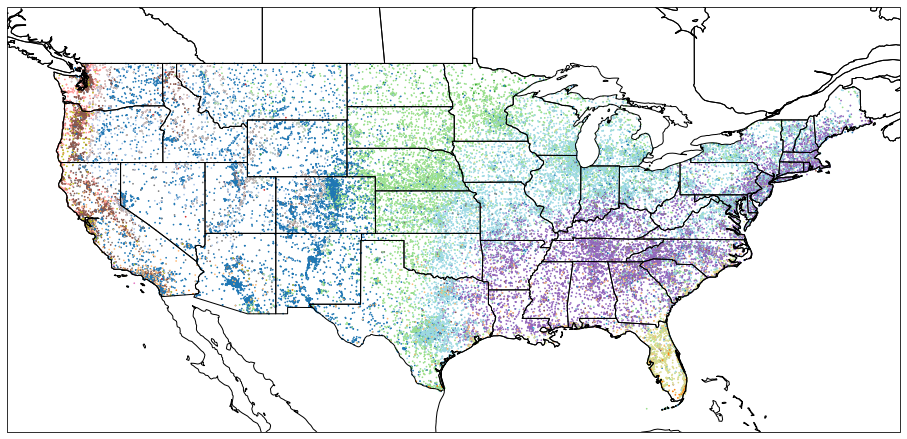

In [30]:
fig = plt.figure(figsize=(16,12))
m_usa = plt.axes(projection=ccrs.PlateCarree())
m_usa.set_extent([-128, -65, 23, 53], ccrs.PlateCarree())
m_usa.add_feature(cfeature.STATES)
m_usa.coastlines()

Lat  = df_final_final["Latitude"].to_numpy()
Long = df_final_final["Longtitude"].to_numpy()
Labs = df_final_final["kmeans_labels"].to_numpy()

m_usa.scatter(Long, Lat, transform=ccrs.PlateCarree(), s=0.5, c=Labs, cmap="tab20")

### This is for 20 clusters, we can use the elbow method to see if there is a critical value for cluster number

In [31]:
'''Using the elbow method to find the optimal number of clusters or the optimal k value

Here we are going with 10 clusters as an arbitary choice and see what is the optimal size of the clusters

What is the optimal size of clusters, it is 5, after k=5 there is no significant change in WCSS

The curve also takes the elbow or curve at k=5

thus all mall customers should be divided into 5 categories

'''

 

'''Initializing the null list '''

'''Calling the class here and creating the object of the respective class

    We are fitting the model with k=1 to 10, init is k-means++ for avaoiding random initialisation trap'''

'''inertia is the other name of wcss in scikit learn and helps to calculate the distance

we are appending the distance to wcsss for all values of k (10-50)

'''

 

wcss = []

for i in range(10, 50):

    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)

    kmeans.fit(X_final)

    wcss.append(kmeans.inertia_)


ValueError: x and y must have same first dimension, but have shapes (25,) and (40,)

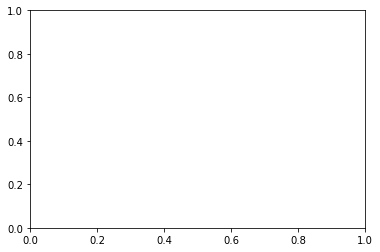

In [32]:
plt.plot(range(10, 35), wcss)

plt.title('The Elbow Method')

plt.xlabel('Number of clusters')

plt.ylabel('WCSS')

plt.show()

In [ ]:
# Fitting K-Means to the mall dataset with 35 clusters

kmeans = KMeans(n_clusters = 35, init = 'k-means++', random_state = 0)

# The fit predict method now seggregates the data in 35 clusters based on the KMeans algo

# The one dimensional array is also called as the vector

y_kmeans = kmeans.fit_predict(X_final)

# Now that we have a model that we are happy with, we can use it to make some predictions

In [ ]:
# function returns nearest station that has been clustered
def find_nearest_station(data_frame, latitude, longtitude):
    p1 = (latitude, longtitude)
    
    # evaluate first row
    row_1 = data_frame.iloc[0]
    lat = row_1['Latitude']
    long = row_1['Longtitude']
    p2 = (lat, long)
    distance = geodesic(p1, p2).miles
    station_id = data_frame.index[0]
    
    for index, row in data_frame.iterrows():
        p2 = (row['Latitude'], row['Longtitude'])
        
        if geodesic(p1, p2).miles < distance:
            distance = geodesic(p1, p2).miles
            station_id = index            
            lat = row['Latitude']
            long = row['Longtitude']

    return station_id, lat, long 

# find_nearest_station(df_final_1, location.latitude, location.longitude)

In [ ]:
# find gps coordinates of address
geolocator = Nominatim(user_agent = "weather_mining")
location = geolocator.geocode("1720 University Blvd, Birmingham, AL 35294")  # 
print(location.address)
print((location.latitude, location.longitude))
print()

In [ ]:
# find nearest station from clustered data
s_id, lat, long = find_nearest_station(df_final_final, location.latitude, location.longitude)
print(f"s_id == {s_id}")
print(f"lat ==  {lat}")
print(f"long == {long}")
print()

# find the cluster grouping of nearest station
cluster_similar = df_final_final.loc[s_id ,'kmeans_labels']
print(f"cluster_similar == {cluster_similar}")

In [ ]:
# find stations in the same cluster assignment
df_final_final_sim = df_final_final.query('kmeans_labels==@cluster_similar')
df_final_final_sim

In [ ]:
# for info
len(df_final_final_sim)

In [42]:
# # returns us zipcodes using gps coordinates in from the weather stations in the same cluster
# list_sim_zips = set()
# for index, row in df_final_final_sim.iterrows():
#     # get address
#     location = geolocator.reverse('{0}, {1}'.format(row['Latitude'], row['Longtitude'])) 
    
#     # get zip code
#     address_list = location.address.split()
#     zip_code = address_list[-3]  # for usa address, the zip code is the third column from the end
#     if zip_code[-1] == ',':
#         zip_code = zip_code[0:-1]
    
#     # save zip code to set
#     if zip_code.isnumeric():
#         list_sim_zips.add(zip_code)


KeyboardInterrupt: 